In [2]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [3]:
def getCalibrationMatrix():

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/*.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
            
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    
    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open( "dist_pickle.p", "wb" ) )
    return (mtx, dist)

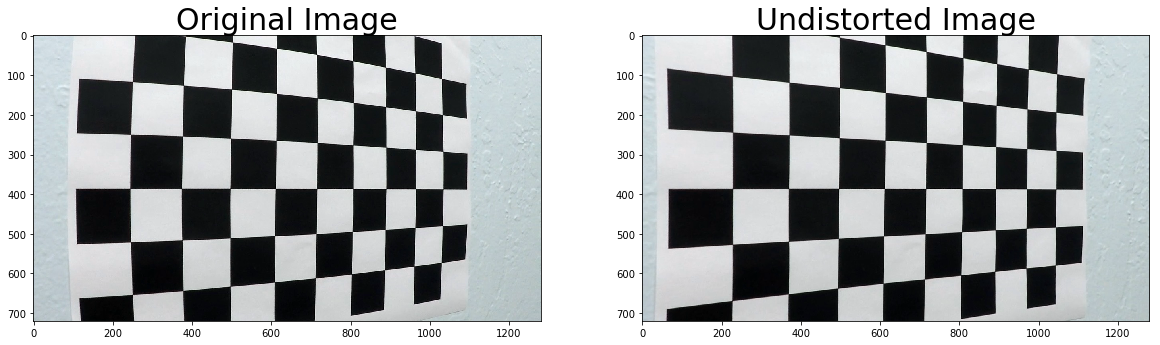

In [4]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration5.jpg')
img_size = (img.shape[1], img.shape[0])

mtx, dist = getCalibrationMatrix()
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

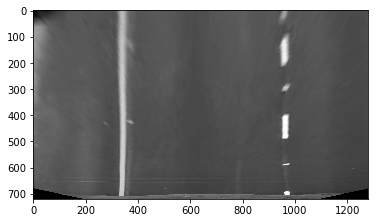

In [5]:
def getPerspectiveTransform():
    src = np.array([[582, 455], [700, 455], [1150, 720], [150, 720]], dtype = np.float32)
    dst = np.array([[300, 0], [1000, 0], [1000, 720], [300, 720]], dtype = np.float32)
    
    M = cv2.getPerspectiveTransform(src, dst)
    return M


M = getPerspectiveTransform()


img = cv2.imread('test_images/straight_lines1.jpg')
img_size = (img.shape[1], img.shape[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
plt.imshow(warped, cmap='gray')

In [102]:
def abs_sobel_thresh(img, orient='x', thresh=(0,255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     img = img[:,:,1]
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    sobel = np.uint8(sobel * 255 / np.max(sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    binary_output = np.zeros_like(sobel)
    binary_output[(sobel >= thresh[0]) & (sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     img = img[:,:,1]
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, sobel_kernel)
    # 3) Calculate the magnitude 
    sobel = (sobelx ** 2 + sobely ** 2) ** 0.5
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    sobel = np.uint8(sobel * 255 / np.max(sobel))
    # 5) Create a binary mask where mag thresholds are met
    
    # 6) Return this mask as your binary_output image
    binary_output = np.zeros_like(sobel)
    binary_output[(sobel >= mag_thresh[0]) & (sobel <= mag_thresh[1])] = 1
    return binary_output
    

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     img = img[:,:,1]
    sobelx = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, sobel_kernel))
    sobely = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, sobel_kernel))
    dire = np.arctan2(sobely, sobelx)
    
    binary_output = np.zeros_like(dire)
    binary_output[(dire >= thresh[0]) & (dire <= thresh[1])] = 1
    binary_output[(dire >= -thresh[0]) & (dire <= -thresh[1])] = 1
    return binary_output

def color_threshold(img, thresh=(0,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return s_channel, s_binary

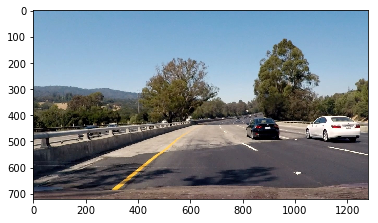

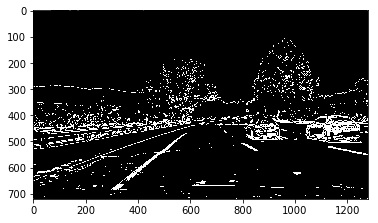

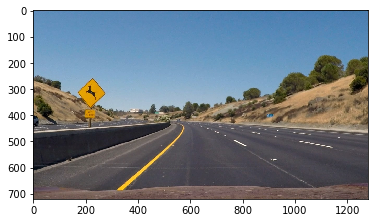

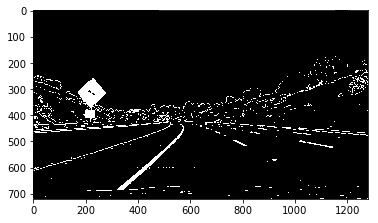

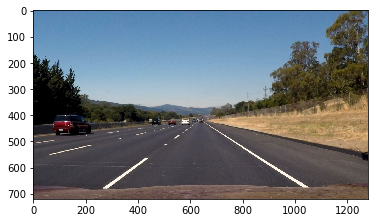

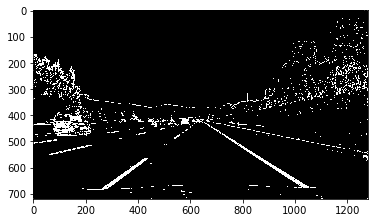

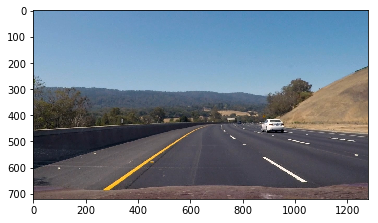

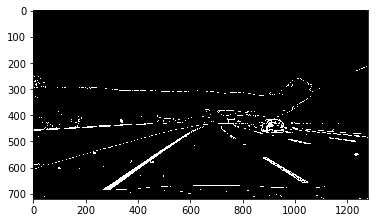

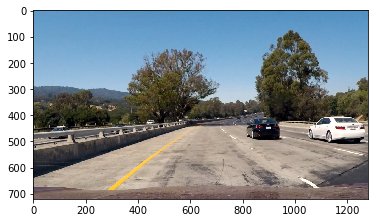

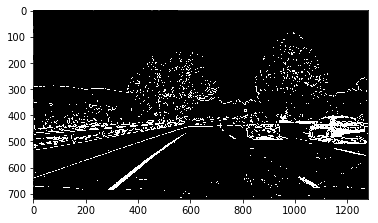

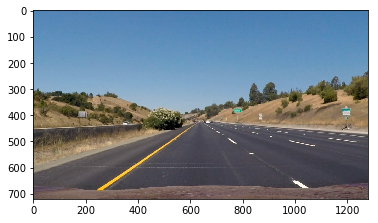

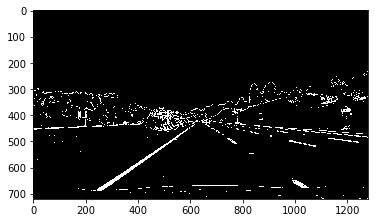

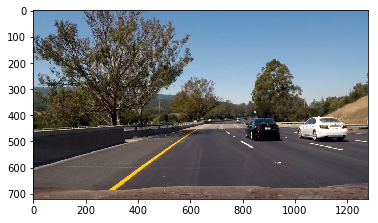

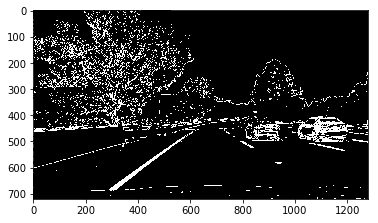

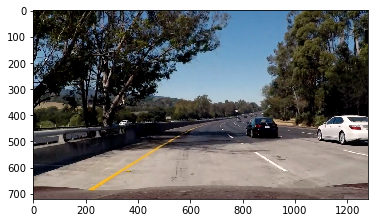

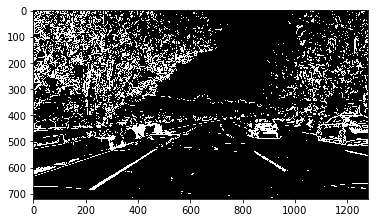

In [127]:
ksize = 5

# Make a list of calibration images
images = glob.glob('test_images/*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    image = mpimg.imread(fname)
    # plt.imshow(image)
    gradx = abs_sobel_thresh(image, orient='x', thresh=(40,250))
    grady = abs_sobel_thresh(image, orient='y', thresh=(50, 250))
    mag_binary = mag_thresh(image, sobel_kernel = ksize, mag_thresh=(50, 250))
    dir_binary = dir_threshold(image, thresh=(0.6, 1.2))
    s_channel, s_binary = color_threshold(image, thresh=(160, 255))
    
    combined = np.zeros_like(dir_binary)
    combined[(s_binary == 1) | ((dir_binary == 1) & (grady == 1)) | ((mag_binary == 1))] = 1
    plt.figure()    
    plt.imshow(image)
    plt.figure()
    plt.imshow(combined, cmap='gray')